# IR-MLP

In [2]:
skip_training = False  # Set this flag to True before validation and submission

In [3]:
# During evaluation, this cell sets skip_training to True

import tools, warnings
warnings.showwarning = tools.customwarn

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F


In [5]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [6]:
# Select device which you are going to use for training
#device = torch.device("cuda:0")
device = torch.device("cpu")

In [7]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

### Input preprocessing

Spatio-temporal coordinate are mapped to a high dimensional space using Fourier features with $L=10$. 

$$\gamma(p) = \{ \sin(2^l \pi p), \cos(2^l \pi p); 0 \leq l < L \}$$
$$ p := (x,y,z,t)$$


In [8]:
def fourier_features_mapping(p, L):
    """ Computes Fourier features as defined in the paper. B may be changed later on.
    Args:
        p of shape (batch_size, p[0]_dim): raw tensor 
    Returns:
        x_out of shape (batch_size, 1, p_dim.shape[1]*2*L) : fourier features of p
    """
    B = torch.tensor([np.pi*2**l for l in range(L)])
    B = B[None, :]
    x_out = torch.empty(p.shape[0], 1, 2*L*p.shape[1])
    
    for i,x in enumerate(p):
        x_proj = x[:,None] * B
        x_out[i] = torch.reshape(torch.cat([torch.sin(x_proj), torch.cos(x_proj)], axis=-1), (1,-1))
#     print(x_out.shape)
    return x_out

In [9]:
# ### Testing
# fs=48000
# t = torch.tensor([[5],[6],[40000]])/fs
# t = fourier_features_mapping(t,10)
# # print(f'T_map shape: {t.shape}')
# # print(t)
# p = torch.tensor([[2,3,5],[4,4,6]])/6
# p = fourier_features_mapping(p,10)
# # print(f'T_map shape: {p.shape}')
# # print(p)
# b = t
# batch_size = p.shape[0]
# time_len = b.shape[0]
# b = np.swapaxes(b, 0,1)
# b = np.repeat(b, batch_size, axis=0)

# a = p
# a = np.repeat(a, time_len, axis=1)
# out = np.concatenate((a,b), axis=-1)
# # print(out.shape)

In [18]:
PADDING_VALUE = 0.0
L = 10
FS = 20
sec = 1

# from torch.nn.utils.rnn import pad_sequence

### may have to deal with differing sample rates later. 
def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (p, tgt_seq) of length batch_size:
          p is of shape (3)
          tgt_seq is of shape (FS*sec)

    Returns:
      pt of shape (batch_size, max_tgt_seq_length, input_mapped_dim): LongTensor of padded source sequences.
      tgt of shape (batch_size, FS*sec): LongTensor of padded target sequences.
    """
    
    p, tgt_seqs = map(list, zip(*list_of_samples))
    
    batch_size = len(p)
#     max_IR_len = max(len(seq) for seq in tgt_seqs)
    IR_len = FS*sec
    
    # calculate Fourier features for positions
    p = torch.stack(p)
    p = fourier_features_mapping(p, L)
    p = np.repeat(p, IR_len, axis=1)
    
    # calculate Fourier features for time
    t = fourier_features_mapping(torch.reshape(torch.arange(0, IR_len), (-1,1))/FS, L)
    t = np.repeat(np.swapaxes(t, 0,1), batch_size, axis=0)
    
    pt = torch.cat((p,t), axis=-1)
#     tgt = pad_sequence(tgt_seqs, batch_first=True)
    
    tgt = torch.stack(tgt_seqs)
    assert tgt.shape == torch.Size([len(tgt_seqs),IR_len]), f'Input tgt_sequence incorrect length: {tgt.shape}'

    return pt, tgt

In [24]:
def test_collate_fn():
    pairs = [
        (torch.tensor([1,2,3]), torch.randn(FS*sec)),
        (torch.tensor([2,1,0]), torch.randn(FS*sec)),
        (torch.tensor([6,3,7]), torch.randn(FS*sec)),
    ]
    pt, tgt = collate(pairs)
    assert pt.shape == torch.Size([3, FS*sec, 80]), f"Bad pt.shape: {pt.shape}"
#     assert pt.dtype == torch.long
    assert tgt.shape == torch.Size([3, FS*sec]), f"Bad tgt.shape: {tgt.shape}"
#     assert tgt.dtype == torch.long, f"Bad tgt.dtype: {tgt.dtype}"
    print('Success')

test_collate_fn()

Success


## Data

In [ ]:
trainset = ________(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, collate, batch_size=16, shuffle=True)

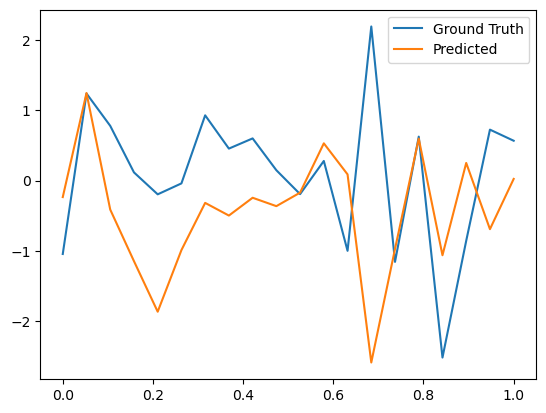

In [48]:
# pos_sample, tgt_sample = trainset[np.random.choice(len(trainset))]
p_sample, tgt_sample = (torch.tensor([1,2,3]), torch.randn(FS*sec)) # stand-in data
tgt_pred = torch.randn(FS*sec)

import matplotlib.pyplot as plt
time_scale = np.linspace(0,sec,FS*sec)
#Plot the data 
fig, ax = plt.subplots(1)
ax.plot(time_scale, tgt_sample, time_scale, tgt_pred)
ax.legend(['Ground Truth','Predicted'])

### Architecture

The architecture reported in the paper is listed here:  
1. full model: fully connected layers=6, hidden size=512, leaky ReLU
2. lightweight model: fully connected layers=6, hidden size=32

Architecture here:
- linear layer (input size, hidden size) + Leaky ReLU 
- linear layer (hidden size, hidden size) + Leaky ReLU 
- linear layer (hidden size, hidden size) + Leaky ReLU 
- linear layer (hidden size, hidden size) + Leaky ReLU 
- linear layer (hidden size, hidden size) + Leaky ReLU 
- linear layer (hidden size, hidden size) + Leaky ReLU 
- linear layer (hidden size, 1)


In [31]:
class IRMLP(nn.Module):
    def __init__(self, num_layers,input_size,hidden_size,negative_slope=0.01):
        super(IRMLP,self).__init__()
        
        linear_stack = [nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope)
        )]
        for _ in range(num_layers-1):
            linear_stack.extend([nn.Linear(hidden_size,hidden_size), nn.LeakyReLU(negative_slope)])
        self.fcn = nn.ModuleList(linear_stack)
        self.output_layer = nn.Linear(hidden_size,1)
        
    def forward(self, x):
        """
        Args:
            x of shape (batch_size*IR_len, input_mapped_dim = 4*2*10 = 80): 
            Tensor with transformed input position vectors.
        
        Returns:
            h_t of shape (batch_size, 1): value for time step t
            
        """
        out = self.fcn(x)
        h_t = self.output_layer(out)
        
        return h_t

### Training
Initialize the IR-MLP model, then train.

In [41]:
num_layers = 6
input_size = 4*20
hidden_size = 32

model = IRMLP(num_layers, input_size, hidden_size).to(device)

In [42]:
if not skip_training:
    EPOCHS = 5
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for pt, tgt in trainloader:
            # Zero gradient of optimizer:
            optimizer.zero_grad()

            # reshape inputs
            batch_size = pt.shape[0]
            pt = pt.view(-1, pt.shape[-1])
            
            # Predict sample at time t
            tgt_pred = model(pt)                        

            loss = criterion(tgt_pred.view(batch_size, -1), tgt)
            loss.backward()

            optimizer.step()
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch}. Loss: {total_loss/(len(trainloader)*FS*sec)}")
        with torch.no_grad():
            model.eval()
            pt, tgt_gt = collate([trainset[np.random.choice(len(trainset))]])
            tgt_pred = torch.flatten(model(pt)) 
    
            time_scale = np.linspace(0,sec,FS*sec)
            #Plot the data 
            fig, ax = plt.subplots(1)
            ax.plot(time_scale, tgt_gt, time_scale, tgt_pred)
            ax.legend(['Ground Truth','Predicted'])


NameError: name 'trainloader' is not defined

In [45]:
x = torch.tensor([[1,2,3],[4,5,6]])
x = x.view(-1,3)
print(x.shape)
print(x)

torch.Size([2, 3])
tensor([[1, 2, 3],
        [4, 5, 6]])
